# Demo 4: Inferring multiple parameters of the Poisson-EI model.
Putting everything together!

In the original model/inference procedure, there was one parameter (E:I ratio) and one readout (1/f exponent), which were monotonically related to each other. Here, we vary multiple model parameters, including time constants, and use all fooof aperiodic readouts to infer them.

By doing so, we get 
1) a distribution of parameter values for the EI model that can (in theory) all produce simulations like the observed data,
2) run simulations using these parameter values, which should all look consistent with the observed data, and
3) fooof these "posterior predictive" simulations to get a probabilistic estimate of the fooof parameters.

In [39]:
# !pip install fooof
# !pip install neurodsp
# !pip install sbi

In [40]:
ON_COLAB = False

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from neurodsp import sim
import fooof
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

cur_dir = 'https://raw.githubusercontent.com/rdgao/specparam-sbi/main/demo_notebooks/' if ON_COLAB else './'
plt.style.use(cur_dir + 'matplotlibrc_notebook.mplstyle')

### Setting some constants.
Note that more of these can be allowed to vary as free parameters.

In [41]:
# Settings for simulation time.
n_seconds = 60
fs = 1000
t_ker=1.
t = np.arange(0,n_seconds, 1/fs)

# Simulation constants
V_rest = -65
V_rev_E = 0
V_rev_I = -80
n_neurons_E = 8000
n_neurons_I = 2000
firing_rate_E = 2
firing_rate_I = 5

# Welch params
nperseg_ratio = 2
noverlap_ratio = 0.5
nperseg = int(nperseg_ratio*fs)
noverlap = int(nperseg*noverlap_ratio)

### Defining a prior distribution for the free parameters.

In [43]:
prior_bounds = torch.Tensor([
    [0.0001,0.0004], # tau_r_E
    [0.0004, 0.005], # tau_d_E
    [0.0002,0.001], # tau_r_I
    [0.005,0.02], # tau_d_E
    [0.5, 8], # EI_ratio    
])

prior = utils.BoxUniform(low=prior_bounds[:,0], high=prior_bounds[:,1])

### Functions for simulation and analysis.

In [44]:
def simulate_ei(params):
    e_params = params[:2]
    i_params = params[2:4]
    ie_ratio = params[4]
    epsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_E, firing_rate_E, e_params[0], e_params[1], t_ker) * (V_rest-V_rev_E)
    ipsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_I, firing_rate_I, i_params[0], i_params[1], t_ker) * (V_rest-V_rev_I)*ie_ratio
    # add components to make LFP
    lfp = epsc + ipsc
    return lfp

def fooof_and_extract(freqs, psds):
    fg = fooof.FOOOFGroup(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
    fg.fit(freqs, psds, freq_range=[0.5,300])
    # Extract FOOOF fits.
    ap_fits = fg.get_params('aperiodic_params')
    f_knee = fooof.utils.params.compute_knee_frequency(ap_fits[:,1], ap_fits[:,2])
    timescale = 1/(f_knee*2*np.pi)
    ap_fits[:,1] = np.log10(timescale)
    errors = fg.get_params('error')
    # Put together as data for training.
    return np.hstack((ap_fits, errors[:,None]))

feature_names = ['offset', 'log10-timescale', 'exponent', 'error']

# Draw prior samples, simulate, and compute summary stats for training.

In [45]:
num_training = 1000
# Draw prior samples.
theta = prior.sample((num_training,))
# Simulate LFPs
lfps = np.array([simulate_ei(th) for th in theta.numpy()])
# Compute PSDs
freqs, psds = signal.welch(lfps, fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
# FOOOF and extract fits.
x = torch.Tensor(fooof_and_extract(freqs, psds))

Running FOOOFGroup across 1000 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/rdgao/miniconda3/envs/sbsp/lib/python3.8/site-packages/fooof/utils/params.py:42: RuntimeWarning: invalid value encountered in power
  return knee ** (1. / exponent)


### Plot some of the prior simulations
Note that they have a range of 1/f exponents, offsets, and knees.

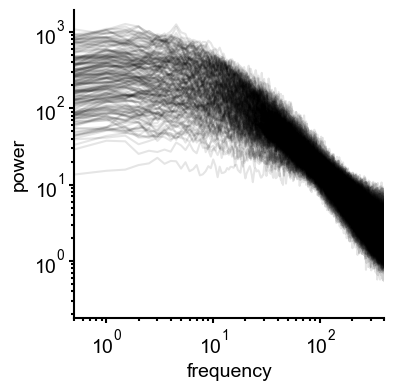

In [50]:
plt.loglog(freqs, psds[:200].T, 'k', alpha=0.1);
plt.xlim([0.5,400])
plt.xlabel('frequency'); plt.ylabel('power'); 

### Plot correlation between parameter and data feature.
Note that some readout features are more correlated with model parameters (e.g., exc decay time constant and 1/f exponent). But in general the affects are distributed, i.e., multiple parameters contribute towards changing a single readout feature, hence reverse inference is not straightforward (cannot just read off the correlations).

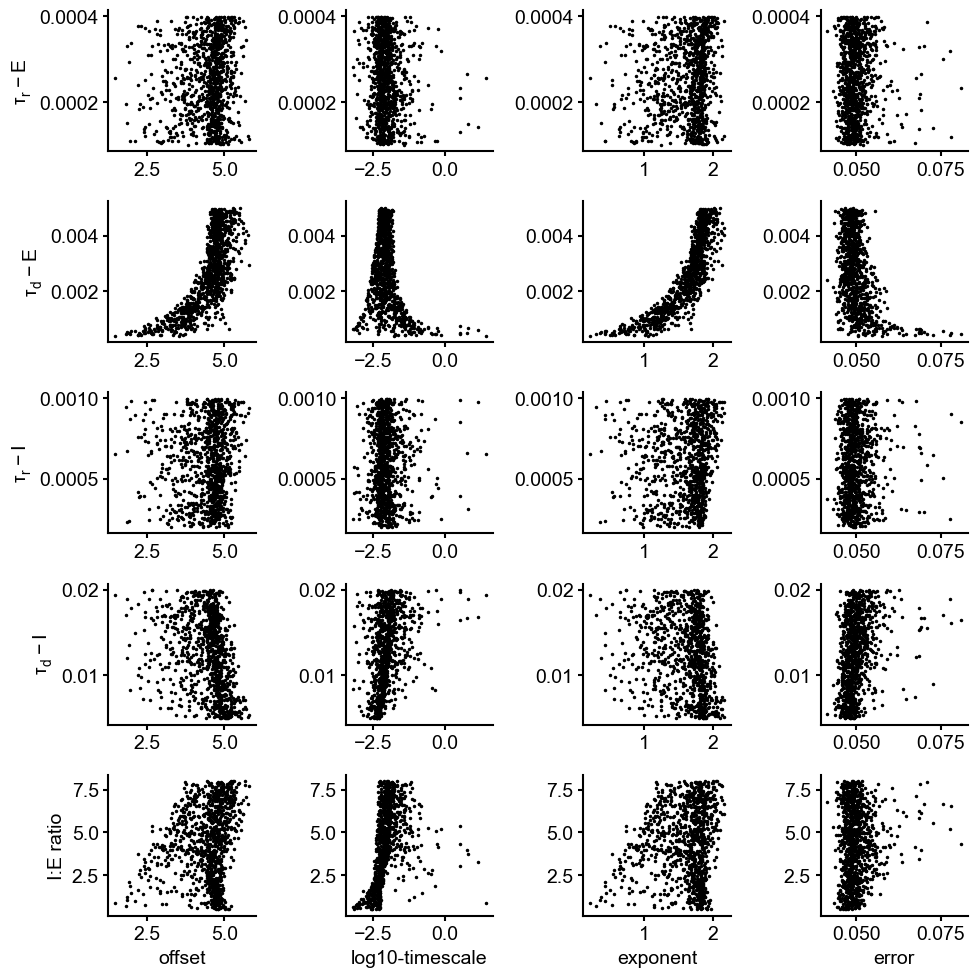

In [51]:
param_names = [r'$\tau_r-E$',r'$\tau_d-E$',r'$\tau_r-I$',r'$\tau_d-I$',r'I:E ratio']
plt.figure(figsize=(2.5*4,2*5))
ctr=1
for i in range(theta.shape[1]):
    for j in range(x.shape[1]):
        plt.subplot(theta.shape[1], x.shape[1],  ctr)
        plt.plot(x[:,j], theta[:,i],  '.')        
        if i==theta.shape[1]-1: plt.xlabel(feature_names[j])
        if j==0: plt.ylabel(param_names[i])
        ctr+=1
        
plt.tight_layout()

### Train (NPE) density estimator.

In [52]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 233 epochs.

### Make a simulated test "observation" data and extract its FOOOF parameters.

In [53]:
theta_o = prior.sample((1,))
freqs, psd_o = signal.welch(simulate_ei(theta_o[0].numpy()), fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
x_o = fooof_and_extract(freqs, psd_o[None,:])

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



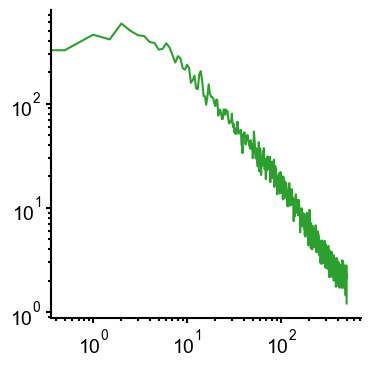

In [54]:
plt.loglog(freqs, psd_o, 'C3')

### Do inference and draw posterior samples.

In [55]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Visualize posterior samples and ground-truth parameter values.
Samples from this (high-dimensional) distribution of parameters are (in theory) all capable of producing simulations that look like the data, and that the ground-truth value (green) is not always at the center of the mass. 

Also notice that some parameters are more constrained (narrower distribution) than others, while there are correlations among parameters 

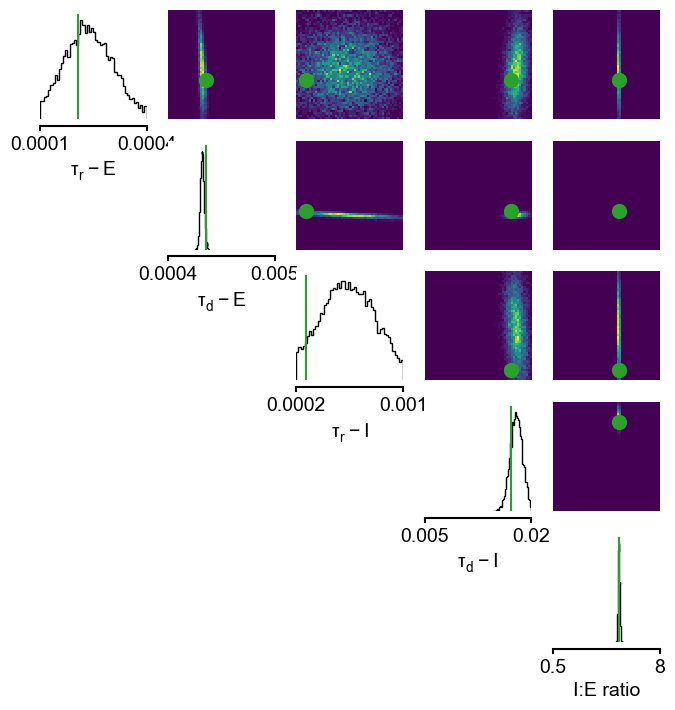

In [68]:
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=prior_bounds, ticks=prior_bounds,
    figsize=(8, 8), labels=param_names,
    points=[theta_o], points_colors=['C3'], # Ground truth parameter value
)

### Simulate and visualize predictive simulation PSDs and FOOOF features.
Simulate some of the posterior samples; they should all produce spectra that look like the test "observation".

In [72]:
predictive_lfps = [simulate_ei(ps) for ps in posterior_samples.numpy()[:1000]]
# Compute PSDs
freqs, predictive_psds = signal.welch(predictive_lfps, fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
predictive_samples = fooof_and_extract(freqs, predictive_psds)

Running FOOOFGroup across 1000 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



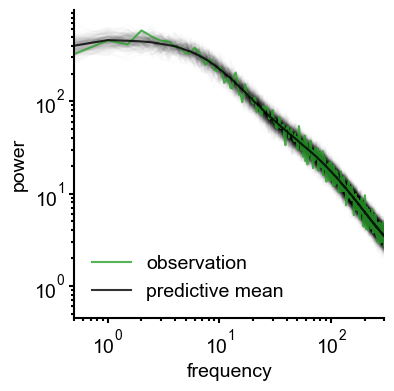

In [75]:
plt.loglog(freqs, predictive_psds[:200].T, 'C0', alpha=0.01);
plt.loglog(freqs, psd_o, 'C3', alpha=0.8, label='observation')
plt.loglog(freqs, predictive_psds.mean(0), 'C0', alpha=0.8, label='predictive mean');
plt.xlabel('frequency'); plt.ylabel('power');
plt.xlim([0.5,300]); plt.legend();

### plot fooof fit of posterior predictive samples
This is a probabilistic estimate of the FOOOF parameters.

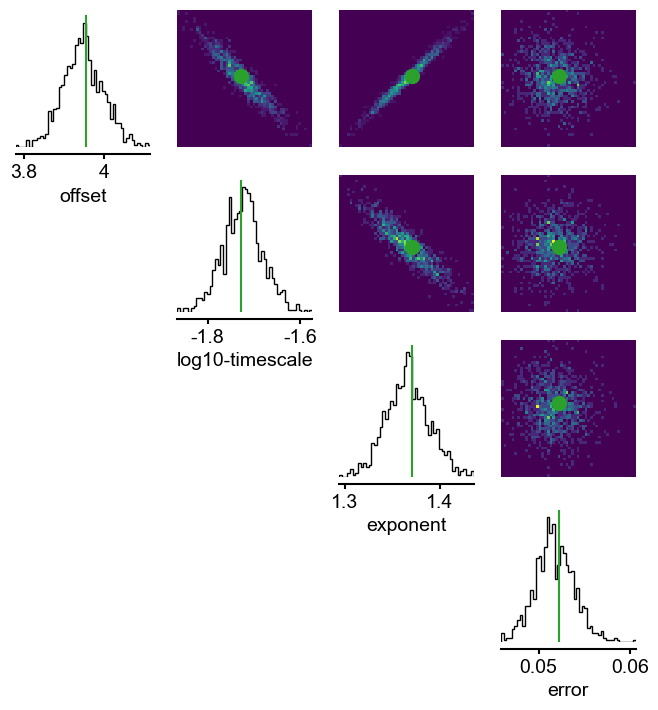

In [76]:
_ = analysis.pairplot(
    predictive_samples, figsize=(8, 8), labels=feature_names,
    points=[torch.Tensor(x_o[0])], points_colors=['C3'],
)

# Immediate extensions:
- make more of the parameters freely varying (firing rates, reversal potentials, etc.)
- include oscillations in the training simulations and summary statistic readouts (have to do some organization given different number of peaks per simulation)
- use a more flexible (non-Poisson) spike generator, such as a population of Hawkes process, or a mass model (e.g., Wilson-Cowan) with its own parameters.
- use the spectrum directly as readout to infer model parameters (without the intermediate fooof summary step)